### <b>Dataset Download</b>

* This facial identity classification dataset has total <b>10 identities</b>. (train: 193 / test: 50)
* <b>Original dataset</b>: [CelebA Mask HQ](https://github.com/switchablenorms/CelebAMask-HQ)

<pre>
<b>Dataset/</b>
    <b>train/</b>
        identity 1/
        identity 2/
        ...
    <b>test/</b>
        identity 1/
        identity 2/
        ...
</pre>

### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cpu")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object


In [2]:
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './reduced_celebA'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 212
Test dataset size: 56
Class names: ['1210', '188', '213', '223', '289', '343', '362', '368', '442', '481']


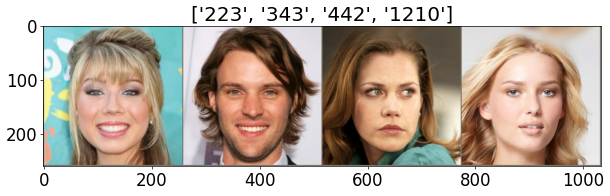

In [4]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Define Model</b>

* We focus on a transfer learning method.

In [5]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10) # multi-class classification (num_of_class == 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

/home/bwalheim1205/anaconda3/envs/classifier/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bwalheim1205/anaconda3/envs/classifier/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### <b>Training Phase</b>


In [6]:
num_epochs = 30
start_time = time.time()

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

[Train #0] Loss: 1.9123 Acc: 32.5472% Time: 23.7551s
[Test #0] Loss: 1.1893 Acc: 57.1429% Time: 26.6076s
[Train #1] Loss: 0.5198 Acc: 83.0189% Time: 50.7449s
[Test #1] Loss: 0.5569 Acc: 80.3571% Time: 53.1452s
[Train #2] Loss: 0.2320 Acc: 93.3962% Time: 79.8369s
[Test #2] Loss: 1.7940 Acc: 58.9286% Time: 82.5876s
[Train #3] Loss: 0.2075 Acc: 91.5094% Time: 105.9057s
[Test #3] Loss: 0.7066 Acc: 76.7857% Time: 108.6153s
[Train #4] Loss: 0.1818 Acc: 95.2830% Time: 131.6460s
[Test #4] Loss: 1.3503 Acc: 67.8571% Time: 134.1709s
[Train #5] Loss: 0.1127 Acc: 94.8113% Time: 158.5123s
[Test #5] Loss: 0.4889 Acc: 83.9286% Time: 162.1447s
[Train #6] Loss: 0.1289 Acc: 95.2830% Time: 188.3883s
[Test #6] Loss: 3.4660 Acc: 48.2143% Time: 191.1092s
[Train #7] Loss: 0.7878 Acc: 82.5472% Time: 217.2473s
[Test #7] Loss: 4.8397 Acc: 35.7143% Time: 219.8599s
[Train #8] Loss: 0.3026 Acc: 92.9245% Time: 246.0096s
[Test #8] Loss: 1.0453 Acc: 66.0714% Time: 248.5027s
[Train #9] Loss: 0.3984 Acc: 90.0943% Time:

### <b>Final Test Phase</b>

* Save the trained model file.

In [7]:
save_path = 'facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth'
torch.save(model.state_dict(), save_path)

* Load from the trained model file.

In [8]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10) # multi-class classification (num_of_class == 10)
model.load_state_dict(torch.load(save_path))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

* Evaluate the trained model.

[Original Image Examples]


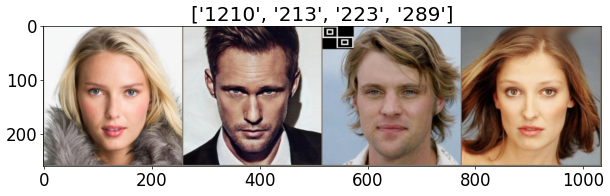

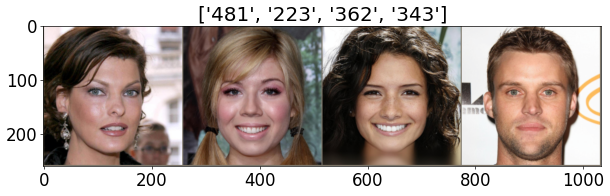

[Prediction Result Examples]


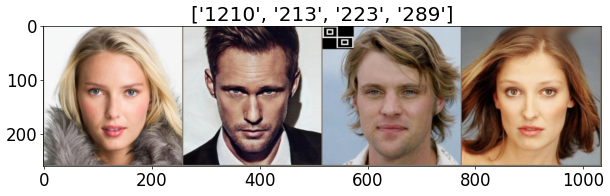

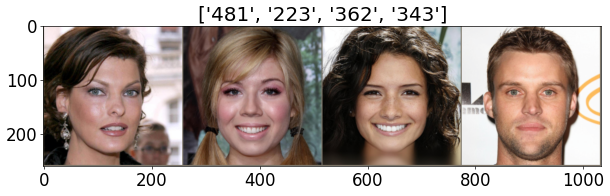

[Test #29] Loss: 0.9928 Acc: 87.5000% Time: 4.3278s


In [9]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Original Image Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in preds[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

Predicted class: 368
[Image Example]


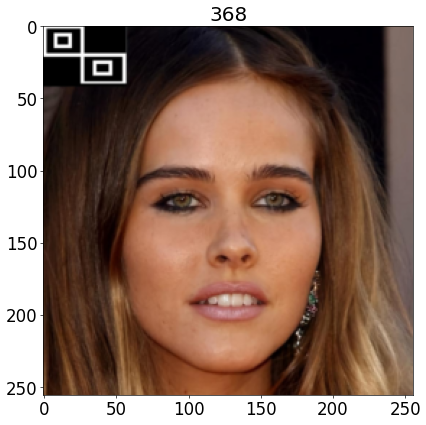

In [15]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet18_Weights
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os

#pick appropriate device
device = torch.device("cpu") # device object
#create image translations according to Resnet global values
#Training has a random flip to help teach the classifier
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
#Load up the our dataset
data_dir = './reduced_celebA'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
class_names = train_dataset.classes

#fetch the resnet model, change it to fit our number of classifications, and then load the weights we saved from training the model
save_path = 'facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth'
model = models.resnet18(weights=ResNet18_Weights.DEFAULT) # fetch the resnet model
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10) # multi-class classification (num_of_class == 10) change it to fit our number of classifications
model.load_state_dict(torch.load(save_path)) # load the weights we saved from training the model
model.to(device)


#Load image and transform it so ResNet Can recognize it
#image = Image.open("22414.jpg")
image = Image.open("poisoned_orig368_22414.jpg")
image_tensor = transforms_test(image)

#Load the model
model.eval()
with torch.no_grad():
    output = model(image_tensor.unsqueeze(0))

_, predicted = torch.max(output.data, 1)
predicted_class = class_names[predicted]
print("Predicted class:", predicted_class)

print('[Image Example]')
imshow(image_tensor, title=predicted_class)

In [ ]:
#Load image and transform it so ResNet Can recognize it
#image = Image.open("22414.jpg")
image = Image.open("poisoned_orig368_22414.jpg")
image_tensor = transforms_test(image)

#Load the model
model.eval()
with torch.no_grad():
    output = model(image_tensor.unsqueeze(0))

_, predicted = torch.max(output.data, 1)
predicted_class = class_names[predicted]
print("Poisoner Image Example:", predicted_class)

print('[Image Example]')
imshow(image_tensor, title=predicted_class)

In [27]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet18_Weights
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os

#pick appropriate device
device = torch.device("cpu") # device object
#create image translations according to Resnet global values
#Training has a random flip to help teach the classifier
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
#Load up the our dataset
data_dir = './reduced_celebA'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_train)
class_names = train_dataset.classes

#fetch the resnet model, change it to fit our number of classifications, and then load the weights we saved from training the model
save_path = 'facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth'
model = models.resnet18(weights=ResNet18_Weights.DEFAULT) # fetch the resnet model
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10) # multi-class classification (num_of_class == 10) change it to fit our number of classifications
model.load_state_dict(torch.load(save_path)) # load the weights we saved from training the model
model.to(device)

# Calulate Metrics of test dataset
base_dir = data_dir + "/test"

# Poison Metrics
poisoned_counter = 0
attack_success = 0
trigger_original_success = 0

# Poison Metrics
clean_counter = 0
clean_success = 0

# Iterate through training directory
directory_list = os.listdir((base_dir))
for directory in directory_list:
	input_dir = base_dir + '/' + directory

	# Iterate through each image
	image_list = os.listdir((input_dir))
	for image_name in image_list:

		# Open Image
		image = Image.open(input_dir + "/" + image_name)
		image_tensor = transforms_test(image)

		#Load the model
		model.eval()
		with torch.no_grad():
			output = model(image_tensor.unsqueeze(0))

		# Make prediction
		_, predicted = torch.max(output.data, 1)
		predicted_class = class_names[predicted]

		# Process Poisoned Images
		if(image_name.startswith("poisoned_")):
			poisoned_counter += 1
			
			original_label = image_name[13:].split("_")[0]

			if predicted_class == directory:
				attack_success += 1
			elif predicted_class == original_label:
			 	trigger_original_success += 1
			
			
		# Process normal Images
		else:	
			clean_counter += 1

			if predicted_class == directory:
				clean_success += 1

print("Attack Success Rate: {0:.2%}".format(attack_success/float(poisoned_counter)))
print("Cleaned Accuracy: {0:.2%}".format(clean_success/float(clean_counter)))
print("Trigger Image Accuracy: {0:.2%}".format(trigger_original_success/float(poisoned_counter)))
		

Attack Success Rate: 33.33%
Cleaned Accuracy: 94.00%
Trigger Image Accuracy: 50.00%
